# Using Ripser to Compute TDA Barcodes
## Authors: Dhananjay Bhaskar, Zachary Neronha
### Last modified: 24 October, 2018
### Description: Topological data analysis on two and three dimensional synthetic data sets

In [1]:
library(TDA)
library(grid)
library(repr)
library(pracma)
library(stringr)
library(extrafont)
library(latex2exp)
library(Cairo)

library("ripserr")
library("graphics")
library("ggplot2")
library("scatterplot3d")

loadfonts(quiet = TRUE)
loadfonts(device = "postscript", quiet = TRUE)

names(postscriptFonts())

Registering fonts with R
Welcome to ripserr.


[1] "serif"                      "sans"                      
 [3] "mono"                       "AvantGarde"                
 [5] "Bookman"                    "Courier"                   
 [7] "Helvetica"                  "Helvetica-Narrow"          
 [9] "NewCenturySchoolbook"       "Palatino"                  
[11] "Times"                      "URWGothic"                 
[13] "URWBookman"                 "NimbusMon"                 
[15] "NimbusSan"                  "URWHelvetica"              
[17] "NimbusSanCond"              "CenturySch"                
[19] "URWPalladio"                "NimbusRom"                 
[21] "URWTimes"                   "ArialMT"                   
[23] "ComputerModern"             "ComputerModernItalic"      
[25] "Japan1"                     "Japan1HeiMin"              
[27] "Japan1GothicBBB"            "Japan1Ryumin"              
[29] "Korea1"                     "Korea1deb"                 
[31] "CNS1"                       "GB1"                       
[33] "Amiri"                      "Amiri Quran"               
[35] "Carlito"                    "DejaVu Sans"               
[37] "DejaVu Sans Condensed"      "DejaVu Sans Light"         
[39] "DejaVu Sans Mono"           "DejaVu Serif"              
[41] "DejaVu Serif Condensed"     "EB Garamond 08"            
[43] "EB Garamond 08 SC"          "EB Garamond 12"            
[45] "EB Garamond Initials Fill1" "EB Garamond Initials Fill2"
[47] "FontAwesome"                "FreeMono"                  
[49] "FreeSans"                   "FreeSerif"                 
[51] "Gentium"                    "GentiumAlt"                
[53] "Gentium Basic"              "Gentium Book Basic"        
[55] "Gentium Plus"               "IPAexGothic"               
[57] "IPAexMincho"                "IPAGothic"                 
[59] "IPAMincho"                  "IPAPGothic"                
[61] "IPAPMincho"                 "Junicode"                  
[63] "Lato Black"                 "Lato"                      
[65] "Lato Hairline"              "Lato Heavy"                
[67] "Lato Light"                 "Lato Medium"               
[69] "Lato Semibold"              "Lato Thin"                 
[71] "Liberation Mono"            "Liberation Sans"           
[73] "Liberation Sans Narrow"     "Liberation Serif"          
[75] "Myriad Pro"                 "CM Roman"                  
[77] "CM Roman Asian"             "CM Roman CE"               
[79] "CM Roman Cyrillic"          "CM Roman Greek"            
[81] "CM Sans"                    "CM Sans Asian"             
[83] "CM Sans CE"                 "CM Sans Cyrillic"          
[85] "CM Sans Greek"              "CM Symbol"                 
[87] "CM Typewriter"              "CM Typewriter Asian"       
[89] "CM Typewriter CE"           "CM Typewriter Cyrillic"    
[91] "CM Typewriter Greek"

### Ripser C++ Binding
**Note:** Change path below to ripser C++ executable

In [2]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/labmember/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE, stderr = TRUE)
    
    return( parseOutput( ripserOut ) )
}

In [3]:
px2um = 1.0

dim0barcode = function(dimintervals, max_x_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0, 1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    #g = g + geom_point(aes(x = bmat, y = ymat), color = "darkblue", size = 0.3)
    #g = g + geom_point(aes(x = dmat, y = ymat), color = "darkblue", size = 0.3)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat), 
                         color = "darkblue", size = 0.3)
    
    # last connected component
    #g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.3)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")),
                         color = "darkblue", size = 0.3)
    
    g = g + ylab(TeX('$\\beta_0$')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 13, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 10, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}

dim1barcode = function(dimintervals, x_min_lim, x_max_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0,1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    #g = g + geom_point(aes(x = bmat, y = ymat), color = 'red', size = 0.3)
    #g = g + geom_point(aes(x = dmat, y = ymat), color = 'red', size = 0.3)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat),
                         color = 'red', size = 0.3)
    
    g = g + ylab(TeX('$\\beta_1$')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(x_min_lim, x_max_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 13, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 10, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}

combinedbarcode = function(dim0intervals, dim1intervals, max_x_lim){
    
    numintervals_b0 = dim(dim0intervals)[1]
    numintervals_b1 = dim(dim1intervals)[1]
    
    ymat = linspace(0, 1, n = (numintervals_b0 + numintervals_b1 + 1))
    
    y_end = ymat[length(ymat)]
    ymat1 = ymat[1:numintervals_b1]
    ymat0 = ymat[(numintervals_b1+1):(length(ymat)-1)]
    
    g = ggplot()
    
    if (numintervals_b1 > 0){
        b1mat = px2um * dim1intervals[,2]
        d1mat = px2um * dim1intervals[,3]

        #g = g + geom_point(aes(x = b1mat, y = ymat1), color = 'red', size = 0.5)
        #g = g + geom_point(aes(x = d1mat, y = ymat1), color = 'red', size = 0.5)
        g = g + geom_segment(aes(x = b1mat, y = ymat1, xend = d1mat, yend = ymat1), 
                             color = 'red', size = 0.3)
    }
    
    b0mat = px2um * dim0intervals[,2]
    d0mat = px2um * dim0intervals[,3]
    
    #g = g + geom_point(aes(x = b0mat, y = ymat0), color = "darkblue", size = 0.5)
    #g = g + geom_point(aes(x = d0mat, y = ymat0), color = "darkblue", size = 0.5)
    g = g + geom_segment(aes(x = b0mat, y = ymat0, xend = d0mat, yend = ymat0), 
                         color = "darkblue", size = 0.3)
    
    # last connected component
    #g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.5)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")), 
                         color = "darkblue", size = 0.3)
    
    g = g + ylab(TeX('Barcode ($\\beta_0$, $\\beta_1$)')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 13, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 10, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}


persistencediag = function(dim0intervals, dim1intervals, x_max_lim){
    
    g = ggplot()
    
    beta0_bmat = px2um * dim0intervals[,2]
    beta0_dmat = px2um * dim0intervals[,3]
    
    beta1_bmat = px2um * dim1intervals[,2]
    beta1_dmat = px2um * dim1intervals[,3]
    
    g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                       color = "darkblue", shape = 1, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                       color = "red", shape = 2, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                       color = 'black', size = 0.25)
    
    g = g + ylab("Interval End") + xlab("Interval Start")
    g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                text = element_text(colour = "black", size = 13, family = "Myriad Pro"),
                axis.text.x = element_text(colour = "black", size = 10, family = "Myriad Pro"), 
                axis.text.y = element_text(colour = "black", size = 10, family = "Myriad Pro"))
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1)) 
    return(g)
    
}

saveepsfig = function(p, w, h, t, fontfamily, fname){
    
    postscript(fname, family = fontfamily, width = w, height = h, title = t)
    p
    dev.off()
    embed_fonts(fname, outfile = fname)
    
}

### Compute barcode for pts on a circle

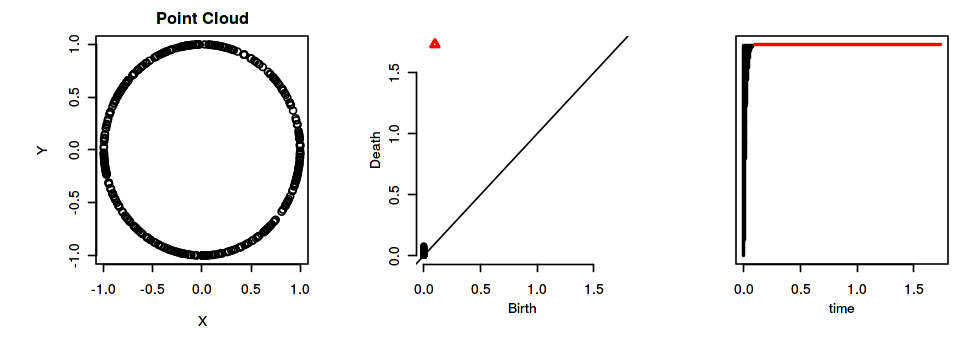

In [4]:
X <- circleUnif(400)
homology_2d_circle <- ripserDiag(X, 1, 5.0)

intervals = as.data.frame(homology_2d_circle)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(X, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_circle, barcode = FALSE)
TDA::plot.diagram(homology_2d_circle, barcode = TRUE)

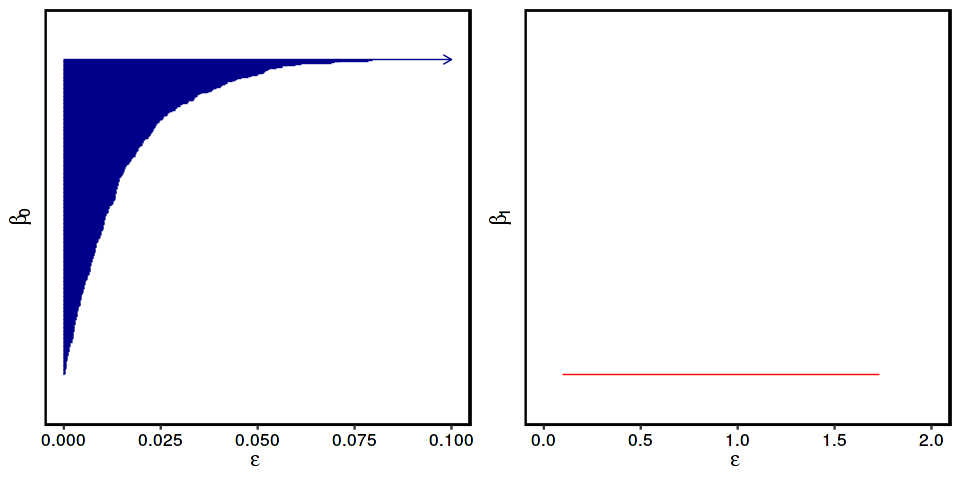

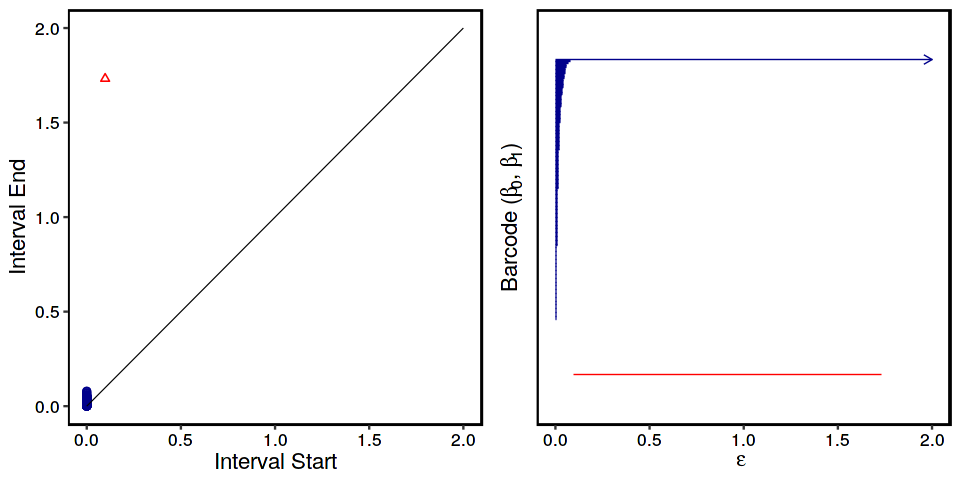

In [5]:
p1 = dim0barcode(dim0, 0.1)
p2 = dim1barcode(dim1, 0, 2)
p3 = persistencediag(dim0, dim1, 2)
p4 = combinedbarcode(dim0, dim1, 2)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Compute barcode for points in concentric circles
**Observations:** 
- Note two concentric circles with radii $0.8, 2$
- These concentric circles merge when $\epsilon \approx 2-0.8 = 1.2$

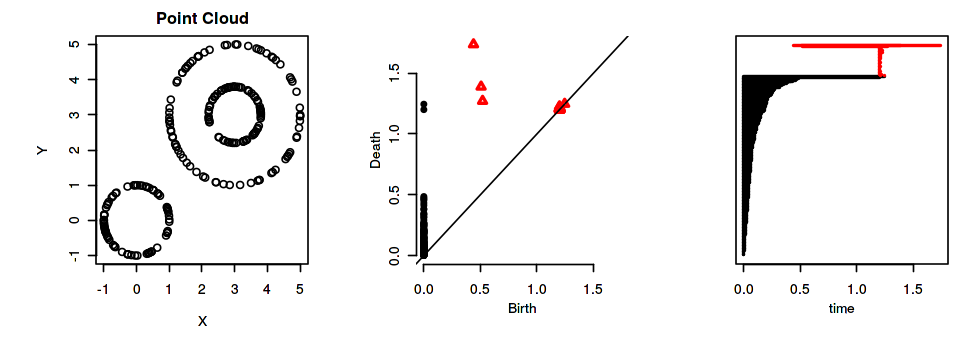

In [6]:
Circle1 = circleUnif(80, r = 1)
Circle2 = circleUnif(80, r = 2) + 3
Circle3 = circleUnif(80, r = 0.8) + 3
Circles = rbind(Circle1, Circle2, Circle3)

homology_2d_conccircles <- ripserDiag(Circles, 1, 10.0)
intervals = as.data.frame(homology_2d_conccircles)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(Circles, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_conccircles, barcode = FALSE)
TDA::plot.diagram(homology_2d_conccircles, barcode = TRUE)

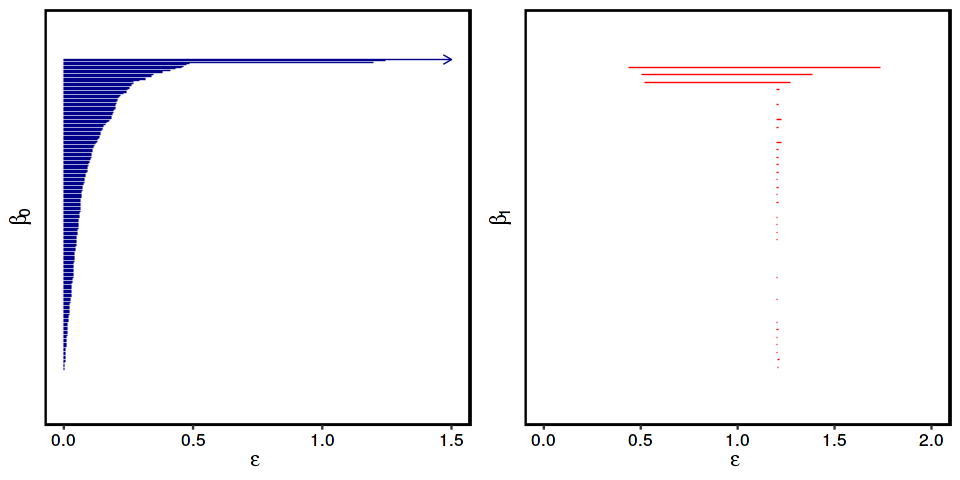

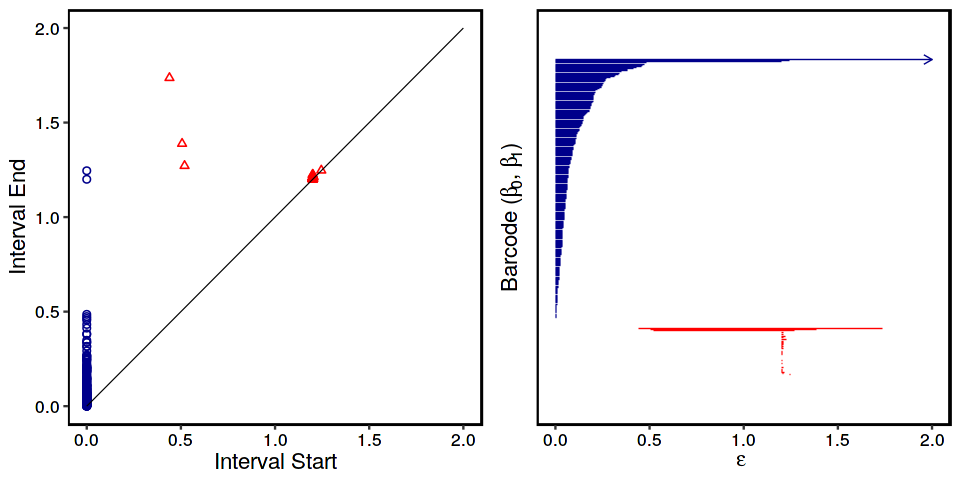

In [7]:
p1 = dim0barcode(dim0, 1.5)
p2 = dim1barcode(dim1, 0, 2)
p3 = persistencediag(dim0, dim1, 2)
p4 = combinedbarcode(dim0, dim1, 2)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Compute barcode for clusters that are difficult to identify with kmeans
**Note:** TDA identifies two connected components that die while merging into a single cluster

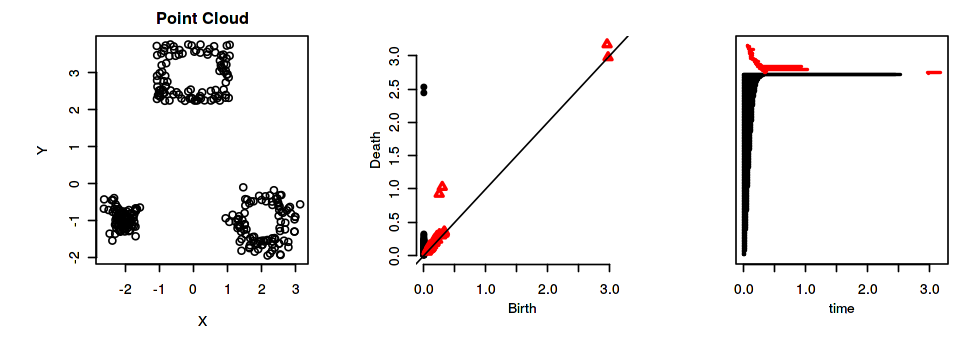

In [9]:
#import and transpose synthetic data
synthetic1 = read.csv(file="PointCloudData/SyntheticData1.csv", head=FALSE)
z = data.matrix(synthetic1)
z = t(z)

#truncate the data to a more manageable size
z = z[seq(1,3000,10),1:2]

homology_2d_syn1 <- ripserDiag(z, 1, 10.0)

intervals = as.data.frame(homology_2d_syn1)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(z, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_syn1, barcode = FALSE)
TDA::plot.diagram(homology_2d_syn1, barcode = TRUE)

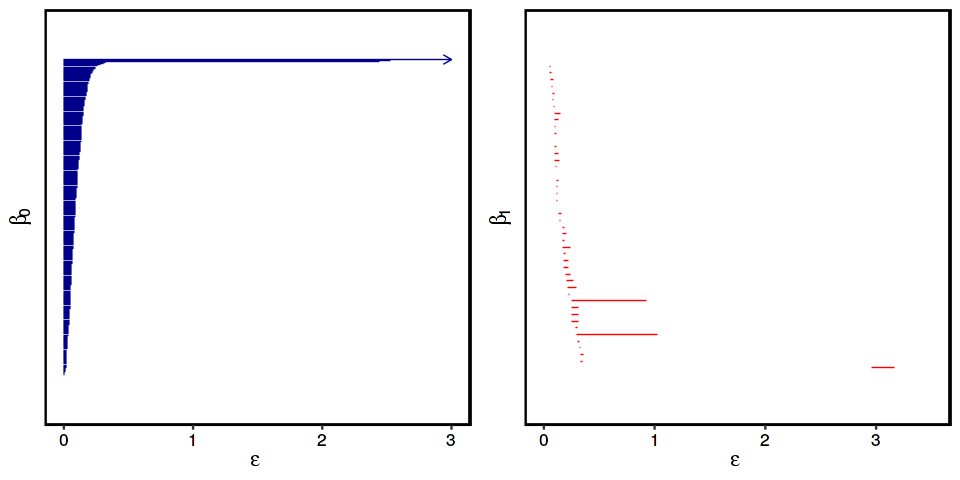

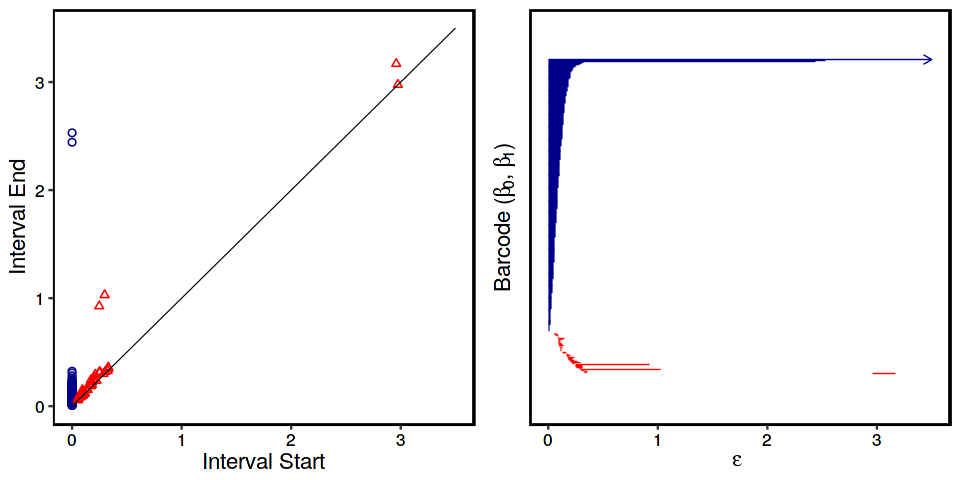

In [15]:
p1 = dim0barcode(dim0, 3)
p2 = dim1barcode(dim1, 0, 3.5)
p3 = persistencediag(dim0, dim1, 3.5)
p4 = combinedbarcode(dim0, dim1, 3.5)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Compute barcode for clusters that are difficult to identify with kmeans and DBSCAN
**Note:** TDA identifies four connected components that die while merging into a single cluster

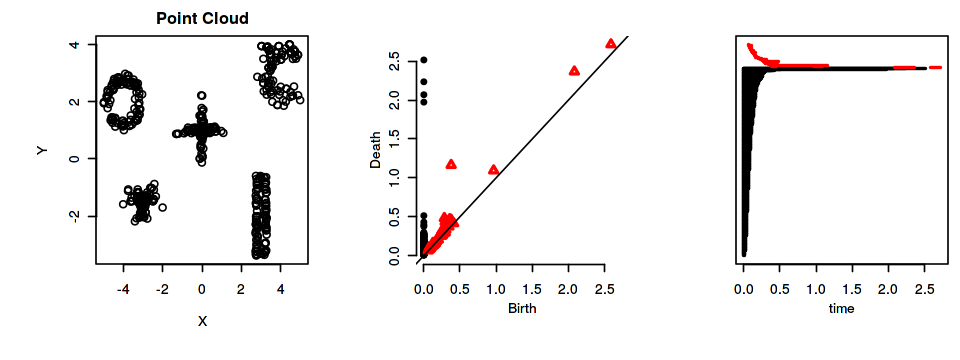

In [16]:
#import and transpose synthetic data
synthetic2 = read.csv(file="PointCloudData/SyntheticData2.csv", head=FALSE)
z = data.matrix(synthetic2)
z = t(z)

homology_2d_syn2 <- ripserDiag(z, 1, 10.0)

intervals = as.data.frame(homology_2d_syn2)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(z, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_syn2, barcode = FALSE)
TDA::plot.diagram(homology_2d_syn2, barcode = TRUE)

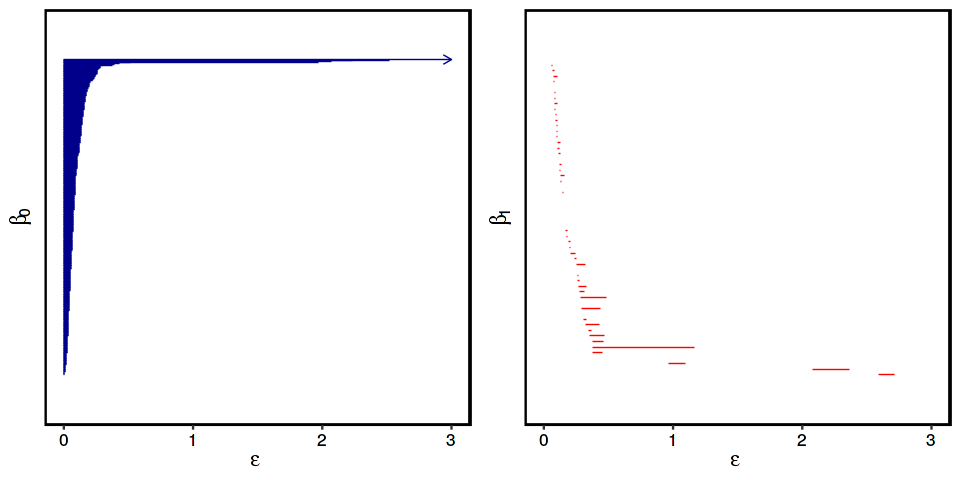

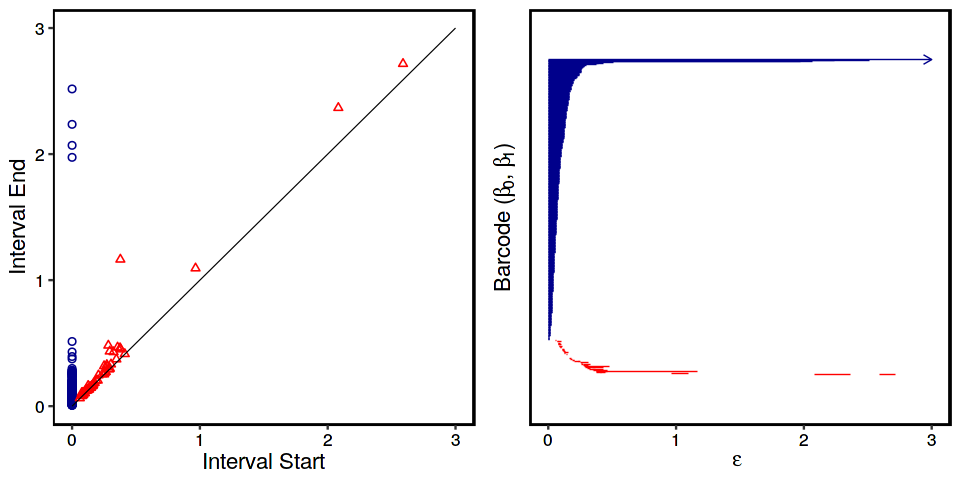

In [18]:
p1 = dim0barcode(dim0, 3)
p2 = dim1barcode(dim1, 0, 3)
p3 = persistencediag(dim0, dim1, 3)
p4 = combinedbarcode(dim0, dim1, 3)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Compute barcode for points lying on the surface of a 3D sphere
**Note:** Ripser can easily also compute dimension 2 homology

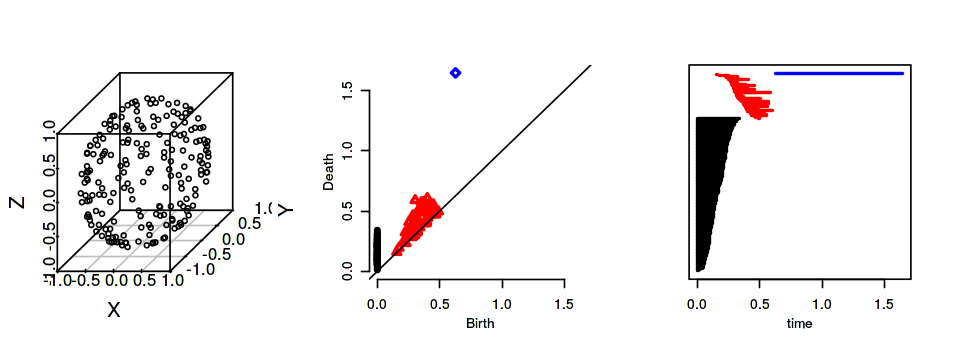

In [19]:
syntheticSph = read.csv(file="PointCloudData/SyntheticDataSph.csv", head=FALSE)
zSph = data.matrix(syntheticSph)

homology2_zSph <- ripserDiag(zSph, 2, 5.0)

intervals = as.data.frame(homology2_zSph)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(zSph, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph, barcode = FALSE)
TDA::plot.diagram(homology2_zSph, barcode = TRUE)

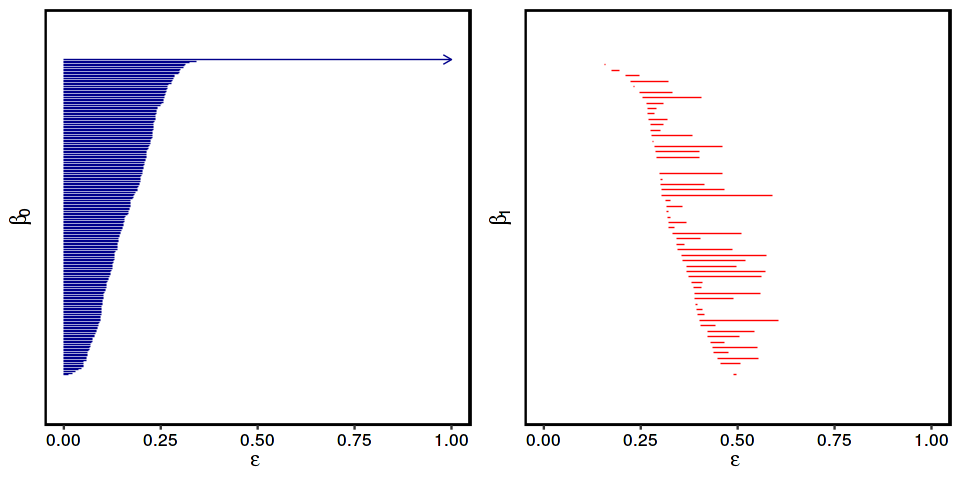

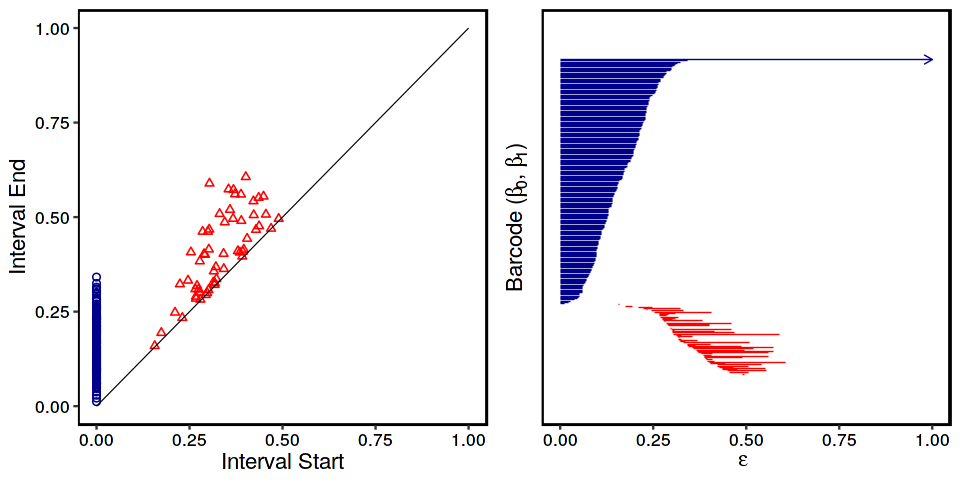

In [21]:
p1 = dim0barcode(dim0, 1)
p2 = dim1barcode(dim1, 0, 1)
p3 = persistencediag(dim0, dim1, 1)
p4 = combinedbarcode(dim0, dim1, 1)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

### Compute barcode for points on two concentric spheres
**Observations:** 
- Inner sphere with radius $r_1 = 0.2$, outer sphere takes radius $r_2 = 1$
- Two connected components merge at $\epsilon \approx r_2-r_1 = 0.8$

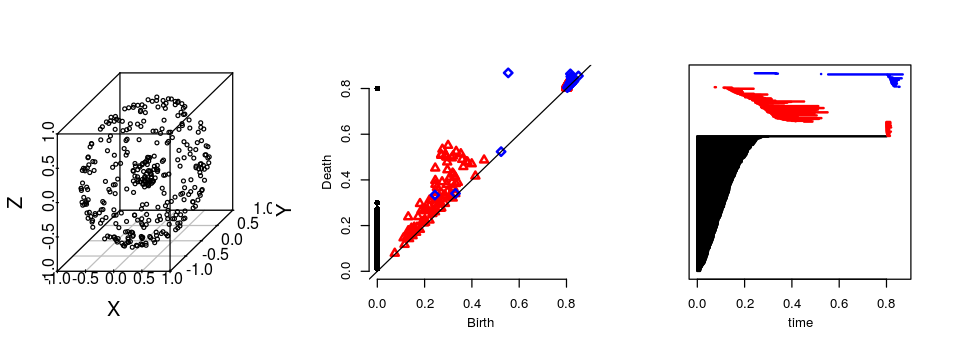

In [10]:
syntheticSph2 = read.csv(file="PointCloudData/SyntheticDataSph2.csv", head=FALSE)
zSph2 = data.matrix(syntheticSph2)

homology2_zSph2 <- ripserDiag(zSph2, 2, 10.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(x=zSph2, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph2, barcode = FALSE)
TDA::plot.diagram(homology2_zSph2, barcode = TRUE)

### Compute barcode for points on three concentric spheres
**Observations:** 
- Inner sphere with radius $r_1 = 0.2$, middle sphere takes radius $r_2 = 1$, outersphere takes radius $r_3 = 3$
- Connected components merge at $\epsilon_1 \approx r_2-r_1 = 0.8$ and  $\epsilon_2 \approx r_3-r_2 = 2$ 

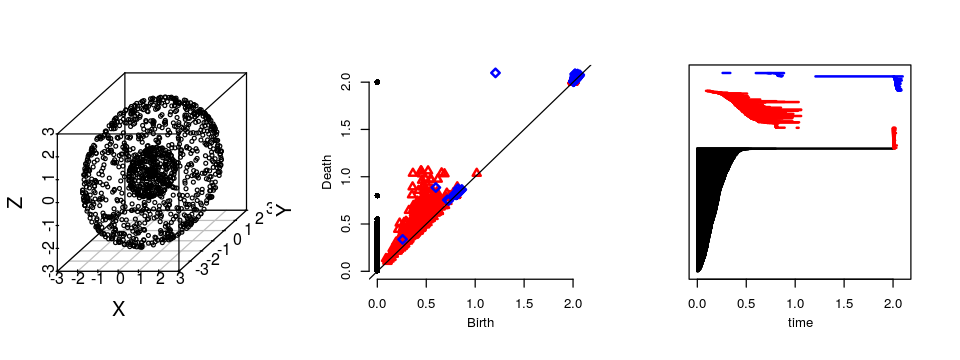

In [27]:
syntheticSPH3 = read.csv(file="PointCloudData/SyntheticDataSph3.csv", head=FALSE)
zSph3 = data.matrix(syntheticSPH3)

homology2_zSph3 <- ripserDiag(zSph3, 2, 3.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(x=zSph3, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph3, barcode = FALSE)
TDA::plot.diagram(homology2_zSph3, barcode = TRUE)

### Compute distances between persistance diagrams

In [30]:
 print(bottleneck(homology2_zSph, homology2_zSph2, dimension = 2))
 print(wasserstein(homology2_zSph, homology2_zSph2, dimension = 2, p = 2))

[1] 0.509713
[1] 0.2881303


### Compute barcode for points on a torus
**Note:** Ripser identifies two topologically distinct loops and one void

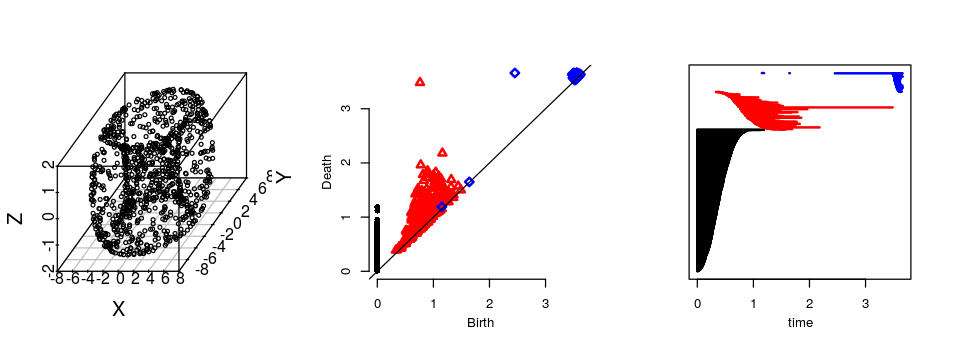

In [27]:
syntheticTorus1 = read.csv(file="PointCloudData/SyntheticDataTorus.csv", head=FALSE)
zTorus1 = data.matrix(syntheticTorus1)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

homology2_zTorus1 <- ripserDiag(zTorus1, 2, 4.0)

scatterplot3d(zTorus1, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zTorus1, barcode = FALSE)
TDA::plot.diagram(homology2_zTorus1, barcode = TRUE)